Loaded: 100 x 300


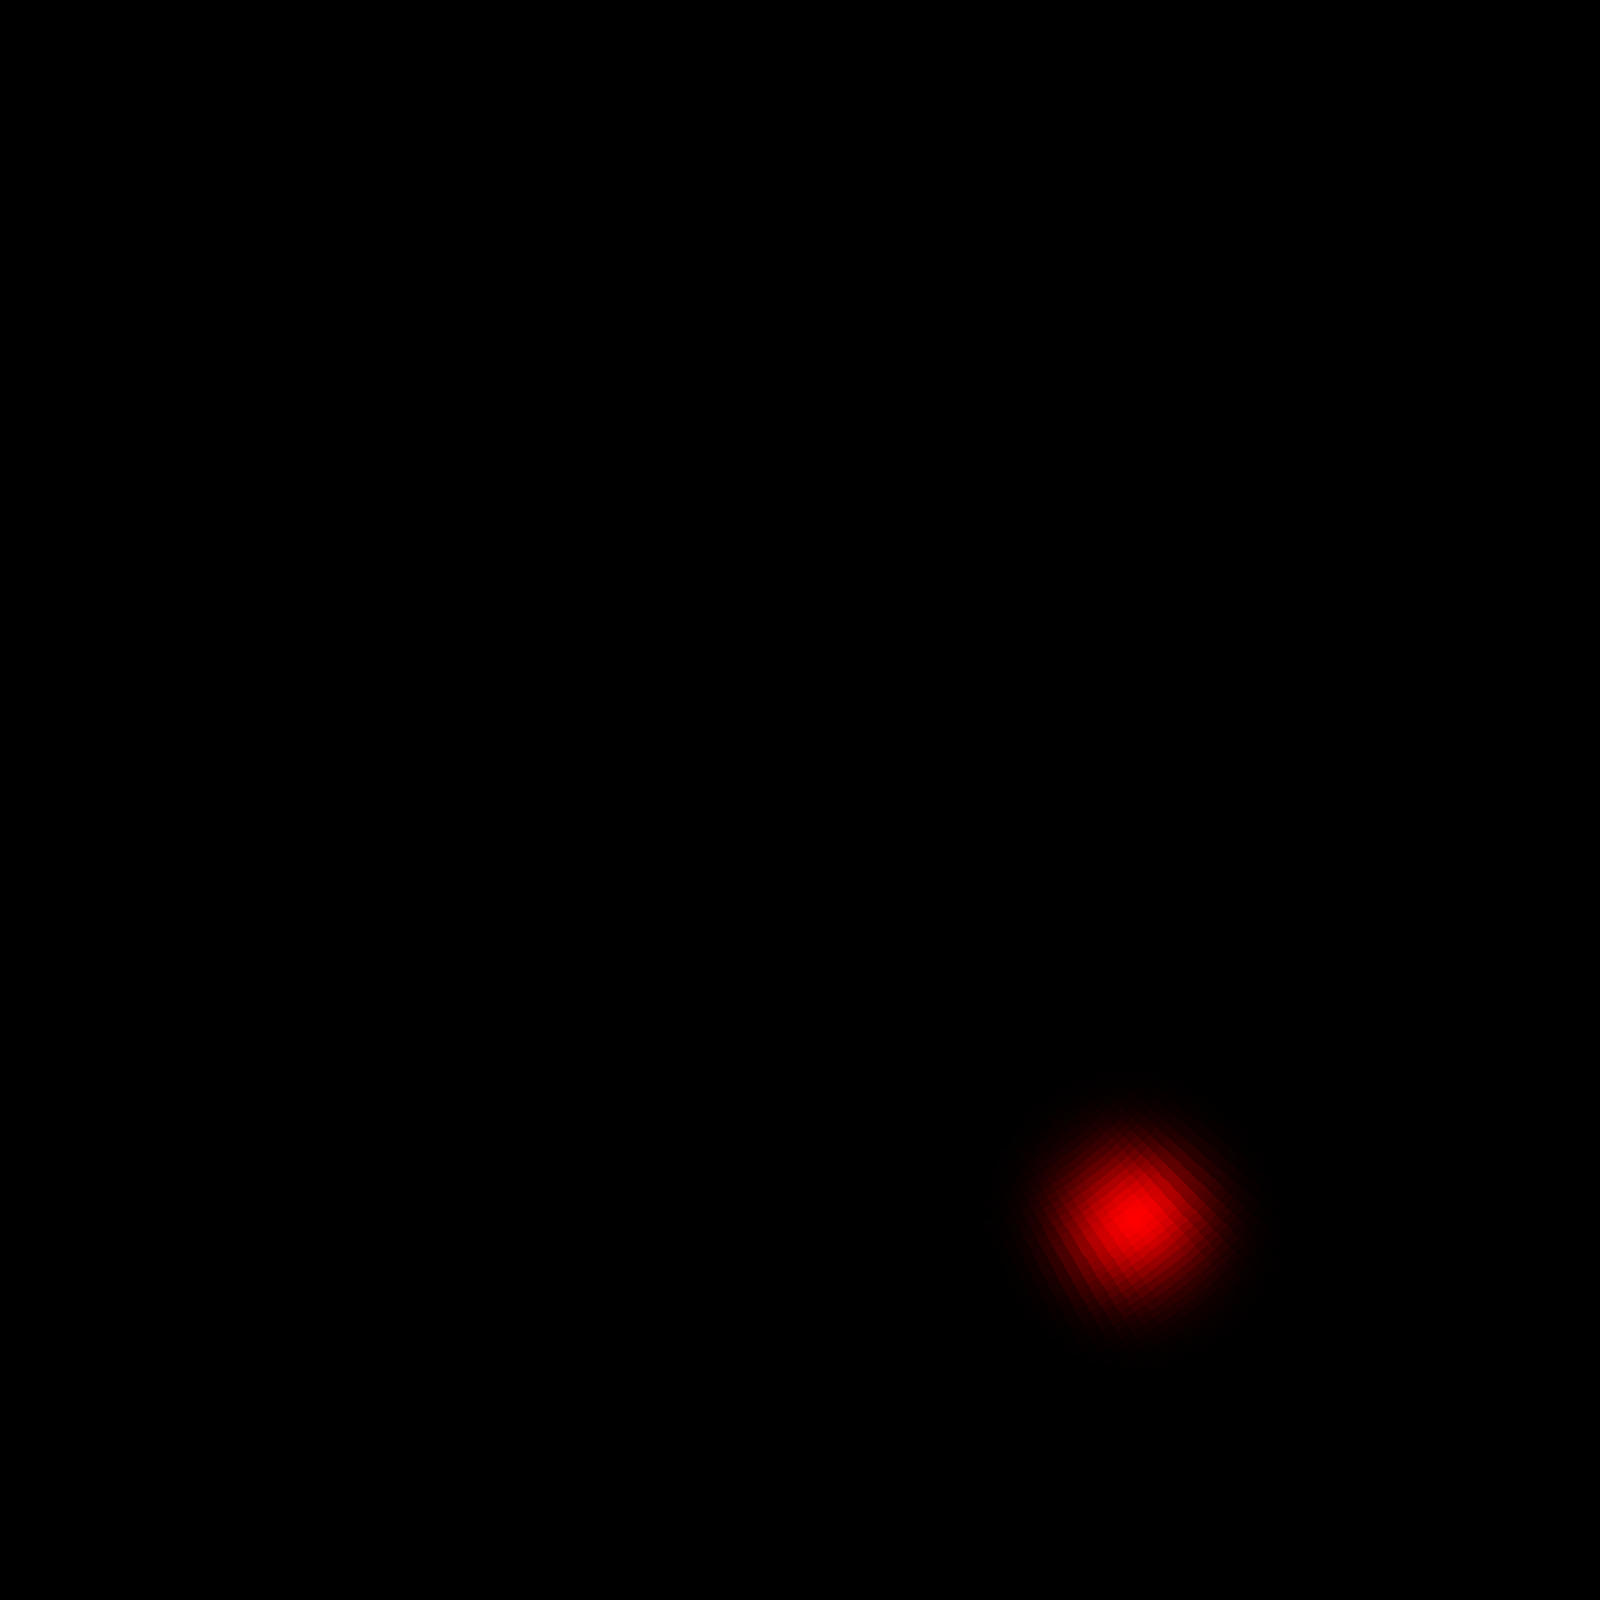

In [ ]:
import struct
import numpy as np
import cv2
from IPython.display import display, Image

# =============================
#   設定
# =============================

def visualize(FNAME):
    # 物理空間の範囲（必要に応じて調整）
    XMIN, XMAX = -60, 60
    YMIN, YMAX = -60, 60

    RES = 1600  # 描画解像度

    # =============================
    #   バイナリ読み込み
    # =============================

    with open(FNAME, "rb") as f:
        Nx = struct.unpack("q", f.read(8))[0]
        Ny = struct.unpack("q", f.read(8))[0]

        vx_all = np.zeros((Nx,Ny,4))
        vy_all = np.zeros((Nx,Ny,4))
        val_all = np.zeros((Nx,Ny))

        for i in range(Nx):
            for j in range(Ny):
                vx = struct.unpack("4d", f.read(32))
                vy = struct.unpack("4d", f.read(32))
                val = struct.unpack("d",  f.read(8))[0]

                vx_all[i,j] = vx
                vy_all[i,j] = vy
                val_all[i,j] = val

    print("Loaded:", Nx, "x", Ny)

    # =============================
    #   正規化 (f → 0–255)
    # =============================
    vmin, vmax = val_all.min(), val_all.max()
    val_norm = (val_all - vmin) / (vmax - vmin + 1e-12)
    val_norm *= 255

    # =============================
    #   world → pixel 変換
    # =============================
    def world_to_img(x, y):
        ix = int((x - XMIN) / (XMAX - XMIN) * RES)
        iy = int((YMAX - y) / (YMAX - YMIN) * RES)
        return (ix, iy)

    # =============================
    #   描画
    # =============================
    img = np.zeros((RES, RES, 3), dtype=np.uint8)

    for i in range(Nx):
        for j in range(Ny):

            pts = np.array([
                world_to_img(vx_all[i,j,k], vy_all[i,j,k])
                for k in range(4)
            ], np.int32)

            color = int(val_norm[i,j])

            cv2.fillPoly(img, [pts], (0,0,color))  # BGR

    # Jupyterで表示
    _, buf = cv2.imencode('.png', img)
    display(Image(data=buf))
